# Prerequisites

This is a notebook uses the pretrained imagenet data as a feature to train classifiers.

How to train an imagenet please refer to my previous notebook ...

In [21]:
import os
import random
import time
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

from PIL import Image
import io
import h5py

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import timm

from sklearn.metrics import hamming_loss, f1_score, roc_curve, auc, classification_report
from sklearn.preprocessing import binarize
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

# Load Data
Load data from previous imagenet output result and train dataset

In [22]:
traindata_path = "isic-2024-challenge/train-metadata.csv"
testdata_path = "isic-2024-challenge/test-metadata.csv"
df_train = pd.read_csv(traindata_path)
df_test = pd.read_csv(testdata_path)

n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Target column = target
target_col = "target"
df_train['fold'] = -1
for idx, (train_idx, val_idx) in enumerate(gkf.split(df_train, df_train[target_col], groups=df_train['patient_id'])):
    df_train.loc[val_idx, 'fold'] = idx

df_train.head(5)

/tmp/ipykernel_478099/2444592733.py:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(traindata_path)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,fold
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,3
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,1
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,4
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,1
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,0


In [23]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl
import pyarrow as pa

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import optuna

# Feature selection and generate new features
This code refer to [...]

In [54]:
id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = [
    'lesion_size_ratio',             # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',            # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                  # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',            # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',       # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',             # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',              # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',          # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',       # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',       # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',   # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',   # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',             # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',             # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',          # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',     # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',         # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',        # border_complexity       + lesion_shape_index
    'color_contrast_index',          # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',               # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',        # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',           # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',              # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',   # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',         # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',      # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',# tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',    # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',          # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',      # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',     # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',         # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',       # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                   # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',       # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',           # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',       # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',       # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient']
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

In [55]:
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), # You may want to impute test data with train
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        # .set_index(id_col)
    )

In [56]:
def preprocess(df_train, df_test):
    global cat_cols
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
    return df_train, df_test

In [139]:
def custom_metric(y_true, y_pred):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    # Ensure inputs are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_pred])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

In [58]:
root = Path('isic-2024-challenge')

train_path = root / 'train-metadata.csv'
test_path = root / 'test-metadata.csv'
subm_path = root / 'sample_submission.csv'


df_train = read_data(train_path)
df_test = read_data(test_path)
df_subm = pd.read_csv(subm_path)

df_train, df_test = preprocess(df_train, df_test)
print(f'Train data shape: {df_train.shape}, Test data shape: {df_test.shape}, Subm data shape: {df_subm.shape}')

Train data shape: (401059, 222), Test data shape: (3, 211), Subm data shape: (3, 2)


In [59]:
# Merge the preoutput result with dataset
pre_result = "oof_predictions.csv"
temp_result = pd.read_csv(pre_result)
df_train = df_train.merge(temp_result[["isic_id", "oof_prediction", "fold"]], on="isic_id", how="left")
df_train.rename(columns={'oof_prediction':'prediction'}, inplace=True)

imagenet_output_result_path = "test_oof_predictions.csv"
imgnet_result = pd.read_csv(imagenet_output_result_path)
df_test = df_test.merge(imgnet_result[["isic_id", "target"]], on="isic_id", how="left")
df_test.rename(columns={'target':'prediction'}, inplace=True)

# Set index to isic_id
df_train.set_index(id_col, inplace=True)
df_test.set_index(id_col, inplace=True)

print(df_train.shape, df_test.shape)

(401059, 223) (3, 211)


# Simply visualize some data

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


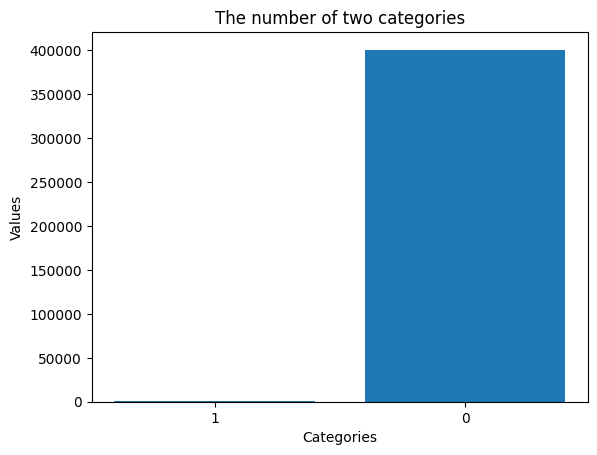

The ratio of two categories: 0.0010


In [60]:
import matplotlib.pyplot as plt

# Plot a bar chart
labels = ["1", "0"]
values = [len(df_train[df_train['target'] == 1]), len(df_train[df_train['target'] == 0])]
plt.bar(labels, values)

# Add title and labels
plt.title('The number of two categories')
plt.xlabel('Categories')
plt.ylabel('Values')

plt.show()

# The ratio of two categories
print(f'The ratio of two categories: {values[0]/values[1]:.4f}')

# Observation
We can clearly see that the the training dataset is huge bias.

# A few models
- xgb
- lightgbm
- catboost

# Classfiers' parameters setup
These parameters refer to [...]

In [142]:
lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'boosting_type':    'gbdt',
    'random_state':     seed,
    'lambda_l1':        0.08758718919397321, 
    'lambda_l2':        0.0039689175176025465, 
    'learning_rate':    0.03231007103195577, 
    'max_depth':        4, 
    'num_leaves':       103, 
    'colsample_bytree': 0.8329551585827726, 
    'colsample_bynode': 0.4025961355653304, 
    'bagging_fraction': 0.7738954452473223, 
    'bagging_freq':     4, 
    'min_data_in_leaf': 85, 
    'scale_pos_weight': 2.7984184778875543,
}

lgb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', lgb.LGBMClassifier(**lgb_params)),
])

In [143]:
cb_params = {
    'loss_function':     'Logloss',
    'iterations':        200,
    'verbose':           False,
    'random_state':      seed,
    'max_depth':         7, 
    'learning_rate':     0.06936242010150652, 
    'scale_pos_weight':  2.6149345838209532, 
    'l2_leaf_reg':       6.216113851699493, 
    'subsample':         0.6249261779711819, 
    'min_data_in_leaf':  24,
    'cat_features':      cat_cols,
}

cb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', cb.CatBoostClassifier(**cb_params)),
])

In [144]:
xgb_params = {
    'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       seed,
    'learning_rate':      0.08501257473292347, 
    'lambda':             8.879624125465703, 
    'alpha':              0.6779926606782505, 
    'max_depth':          6, 
    'subsample':          0.6012681388711075, 
    'colsample_bytree':   0.8437772277074493, 
    'colsample_bylevel':  0.5476090898823716, 
    'colsample_bynode':   0.9928601203635129, 
    'scale_pos_weight':   3.29440313334688,
}

xgb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', xgb.XGBClassifier(**xgb_params)),
])

In [145]:
estimator = VotingClassifier([
    ('lgb', lgb_model), ('cb', cb_model), ('xgb', xgb_model),
], voting='soft')

# Training Models

## Train function

In [146]:
def hill_climbing(x, y, x_test, scoring=None):
    
    # Each column in x is each model's prediciton proba
    # Each fold will call this function one time
    
    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        if scoring is not None:
            scores[col] = scoring(y, x[col])
        else:
            scores[col] = roc_auc_score(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    if scoring is not None:
        history = [scoring(y, current_best_ensemble)]
    else:
        history = [roc_auc_score(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        if scoring is not None:
            print(y.shape)
            potential_new_best_cv_score = scoring(y, current_best_ensemble)
        else:
            potential_new_best_cv_score = roc_auc_score(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                if scoring is not None:
                    cv_score = scoring(y, potential_ensemble)
                else:
                    cv_score = roc_auc_score(y, potential_ensemble)
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True
        
    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds
    
    return [hill_ens_pred_1, hill_ens_pred_2]

In [147]:
def hill_climbing_random_weight(x:pd.DataFrame, y: pd.DataFrame, x_test: pd.DataFrame, scoring=None, num_epochs=100):
    
    # Each column in x is each model's prediciton proba
    # Each fold will call this function one time
    
    n = len(x.columns)

    # Initialize random weights and normalize
    random_weight = np.random.rand(n)
    random_weight /= random_weight.sum()
    best_weight = random_weight
    random_weight = random_weight.reshape((n, 1))  # Reshape for matrix multiplication

    # Multiple x and random_weight
    best_score = .0
    val_pred = pd.DataFrame(data=np.zeros((len(x), 1)))
    test_pred = pd.DataFrame(data=np.zeros((len(x_test), 1)))

    for i in range(0, num_epochs):
        np_x = x.to_numpy()
        temp_pred = np.matmul(np_x, random_weight).ravel()
        print(temp_pred.shape)
        if scoring is not None:
            # print(y.head())
            # print(df_temp_pred.head())
            temp_score = scoring(y, temp_pred)
        else:
            temp_score = roc_auc_score(y, temp_pred)

        if temp_score > best_score:
            best_score = temp_score
            # Update best result
            val_pred = temp_pred
            np_xtest = x_test.to_numpy()
            test_pred.iloc = np.matmul(np_xtest, random_weight)
            best_weight = random_weight

    print(f'Best weight:{best_weight}')
    return [val_pred, test_pred]

In [148]:
def train_evaluate_models(models: dict, n_splits: int, X: pd.DataFrame, y: pd.DataFrame, X_test: pd.DataFrame, scoring=None, random_weight=False):
    dfs_test_pred = {model:pd.DataFrame() for model in (*models.keys(), 'average_ens', 'hill_ens')} # Store every models' every folds' test prediction result
    
    dfs_columns = list(model for model in (*models.keys(), 'average_ens', 'hill_ens'))
    df_val_score = pd.DataFrame(data=np.zeros((n_splits, len(dfs_columns))), columns=dfs_columns) # Store every models' every folds' validation score
    
    # Using StratifiedKFold
    # skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    gkf = GroupKFold(n_splits=n_splits)
    for fold in range(n_splits):
        print(f'\033[1;35m=====================Fold:{fold}=====================\033[0m')
        X_train, y_train = X[X['fold'] != fold].drop('fold', axis=1), y[y['fold'] != fold].drop('fold', axis=1)
        X_val, y_val = X[X['fold'] == fold].drop('fold', axis=1), y[y['fold'] == fold].drop('fold', axis=1)
        # X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        # X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        each_fold_val_pred = pd.DataFrame(columns=list(models.keys()))
        each_fold_test_pred = pd.DataFrame(columns=list(models.keys()))
        
        for model_name, model in models.items():
            # Fit model
            model.fit(X_train, y_train)
            
            # Evaluate model
            y_val_pred = model.predict_proba(X_val)[:,1]
            if scoring is not None:
                auc = scoring(y_val, y_val_pred)
            else:
                auc = roc_auc_score(y_val, y_val_pred)
            df_val_score.loc[fold, model_name] = auc
            each_fold_val_pred[model_name] = y_val_pred
            
            # Predict test data without answer
            y_test_pred = model.predict_proba(X_test)[:,1]
            dfs_test_pred[model_name][f'Fold{fold}'] = y_test_pred
            each_fold_test_pred[model_name] = y_test_pred
            
            print(f'\033[1;33m{model_name} oof ROC-AUC score ==> {auc}')
    
        # Average Ensemble
        avg_ens_val_pred = each_fold_val_pred.mean(axis=1).to_numpy()
        if scoring is not None:
            auc = scoring(y_val, avg_ens_val_pred)
        else:
            auc = roc_auc_score(y_val, avg_ens_val_pred)
        df_val_score.loc[fold, 'average_ens'] = auc
        dfs_test_pred['average_ens'][f'Fold{fold}'] = each_fold_test_pred.mean(axis=1)
        print(f'\033[1;33mAverage Ensemble oof ROC-AUC score ==> {auc}')
        
        # Hill Climbing Ensemble
        if random_weight == False:
            hill_results = hill_climbing(each_fold_val_pred, y_val, each_fold_test_pred, scoring=scoring)
        else:
            # print(each_fold_val_pred.shape)
            # print(y_val.shape)
            hill_results = hill_climbing_random_weight(each_fold_val_pred, y_val, each_fold_test_pred, scoring=scoring)
        if scoring is not None:
            auc = scoring(y_val, hill_results[0])
        else:
            auc = roc_auc_score(y_val, hill_results[0])
        df_val_score.loc[fold, 'hill_ens'] = auc
        dfs_test_pred['hill_ens'][f'Fold{fold}'] = hill_results[1]
        print(f'\033[1;33mHill Climbing Ensemble oof ROC-AUC score ==> {auc}')

    avg_scores = df_val_score.mean(axis=0)
    print(f'\033[1;35m===============================================\033[0m')
    for index, value in avg_scores.items():
        print(f'\033[1;34mAverage of {index} oof ROC-AUC score ==> {value}\033[0m')
    return df_val_score, dfs_test_pred

## Consolidate models into dictionary

In [149]:
vot_estimator = VotingClassifier([
    ('lgb', lgb_model), ('cb', cb_model), ('xgb', xgb_model),
], voting='soft')
models = {'xgb': xgb_model, 'lgb': lgb_model, 'cat': cb_model, 'vot': vot_estimator}

In [150]:
X = df_train[[*feature_cols, 'fold']]
y = df_train[[target_col, 'fold']]
df_val_score_rw, dfs_test_pred_rw = train_evaluate_models(models, n_splits, X, y, df_test[feature_cols], scoring=custom_metric, random_weight=True)
df_val_score, dfs_test_pred = train_evaluate_models(models, n_splits, X, y, df_test[feature_cols], scoring=custom_metric)

print(df_val_score, df_val_score_rw)

=====================Fold:0=====================
xgb oof ROC-AUC score ==> 0.1802511662478713


/home/myuser/Documents/kaggle-ISIC/kaggle-venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/myuser/Documents/kaggle-ISIC/kaggle-venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/myuser/Documents/kaggle-ISIC/kaggle-venv/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


lgb oof ROC-AUC score ==> 0.18106282484371444
cat oof ROC-AUC score ==> 0.18235720743957975


/home/myuser/Documents/kaggle-ISIC/kaggle-venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/myuser/Documents/kaggle-ISIC/kaggle-venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/myuser/Documents/kaggle-ISIC/kaggle-venv/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


vot oof ROC-AUC score ==> 0.1836029154810044
Average Ensemble oof ROC-AUC score ==> 0.1836029154810044
(80214,)


/tmp/ipykernel_478099/1778731998.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test_pred.iloc = np.matmul(np_xtest, random_weight)


AttributeError: can't set attribute 'iloc'

In [ ]:
result = xgb_model.predict_proba(X[feature_cols])[:,1]


In [ ]:
np.asarray(y)

array([[0, 3],
       [0, 1],
       [0, 4],
       ...,
       [0, 2],
       [0, 4],
       [0, 0]])